# Data fields
 * DBNOs - Number of enemy players knocked.
 * assists - Number of enemy players this player damaged that were killed by teammates.
 * boosts - Number of boost items used.
damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
 * headshotKills - Number of enemy players killed with headshots.
heals - Number of healing items used.
 * Id - Player’s Id
 * killPlace - Ranking in match of number of enemy players killed.
 * killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
 * killStreaks - Max number of enemy players killed in a short amount of time.
 * kills - Number of enemy players killed.
 * longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
 * matchDuration - Duration of match in seconds.
 * matchId - ID to identify match. There are no matches that are in both the training and testing set.
 * matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
 * rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
 * revives - Number of times this player revived teammates.
 * rideDistance - Total distance traveled in vehicles measured in meters.
 * roadKills - Number of kills while in a vehicle.
 * swimDistance - Total distance traveled by swimming measured in meters.
 * teamKills - Number of times this player killed a teammate.
 * vehicleDestroys - Number of vehicles destroyed.
 * walkDistance - Total distance traveled on foot measured in meters.
 * weaponsAcquired - Number of weapons picked up.
 * winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
 * groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
 * numGroups - Number of groups we have data for in the match.
 * maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
 * winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

Na zaklade groupId a Id a matchType treba vytvorit novy atribut numOfPlayersInSquad, v ktorom bude pocet hracov v danej hre. Pretoze squad atd nemusi nutne znamenat ze tam hraju styria hraci

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression, RFE, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import json
from sklearn import metrics
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df_stats = pd.read_csv('gdrive/My Drive/OZNAL/new/train_V2.csv')

# Describes

In [0]:
df_stats.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [0]:
df_stats.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.000000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,84.2400,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,47.0000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.000000,20.0


In [0]:
df_stats.describe(exclude=np.number).T

,count,unique,top,freq
Id,4446966,4446966,07f2a6b7d011eb,1
groupId,4446966,2026745,14d6b54cdec6bc,74
matchId,4446966,47965,3596552d3443db,100
matchType,4446966,16,squad-fpp,1756186


# Analysis

## Correlations

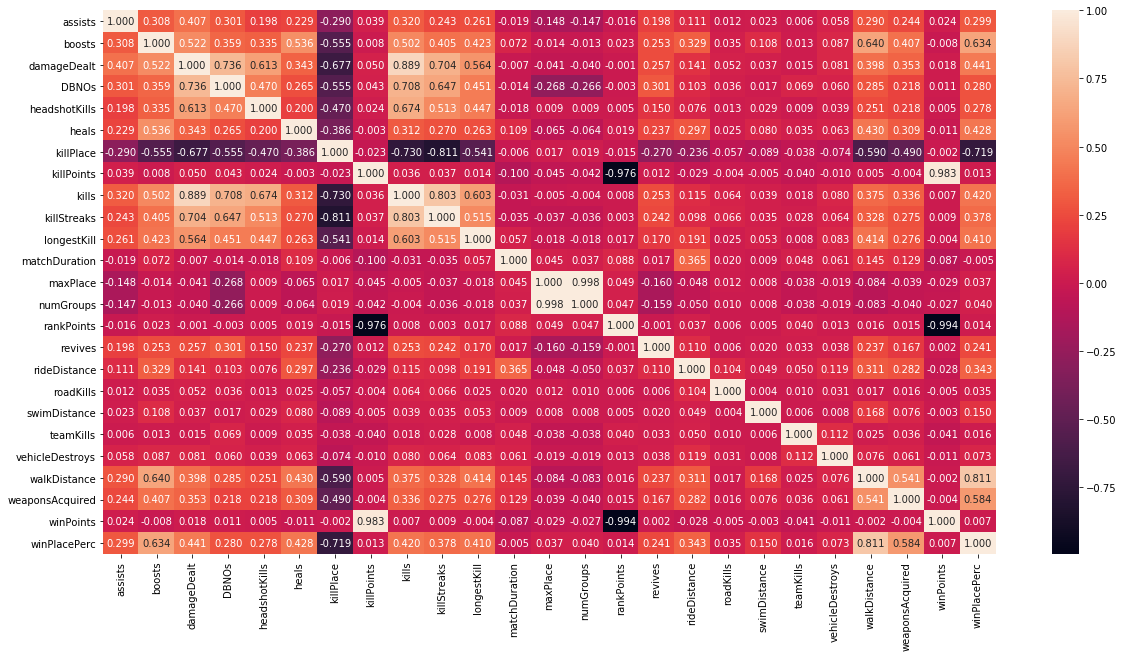

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_stats.corr(), ax=ax, annot=True, fmt=".3f")

In [0]:
def get_positive_negative_corrs(df, threshold, is_positive):
  corr_matrix = df.corr()
  if is_positive:
    high_corr_var=np.where(corr_matrix>=threshold)
  else:
    high_corr_var=np.where(corr_matrix<=threshold)
  return [(corr_matrix.columns[x],corr_matrix.columns[y]) 
         for x,y in zip(*high_corr_var) if x!=y and x<y]
def get_mean_median(df):
  counter = 0
  list_modes = df.matchType.unique()
  list_modes.sort()
  max_counter = len(list_modes)
  standard_modes_median = dict()
  standard_modes_mean = dict()
  for i in list_modes:
    standard_modes_median[i] = df[df.matchType == i].winPlacePerc.median()
    standard_modes_mean[i] = df[df.matchType == i].winPlacePerc.mean()
  df_median = pd.DataFrame(standard_modes_median, index=['median'])
  df_mean = pd.DataFrame(standard_modes_mean, index=['mean'])
  return pd.concat([df_median, df_mean])

In [0]:
print(get_positive_negative_corrs(df_stats, 0.7, True))

[('damageDealt', 'DBNOs'), ('damageDealt', 'kills'), ('damageDealt', 'killStreaks'), ('DBNOs', 'kills'), ('killPoints', 'winPoints'), ('kills', 'killStreaks'), ('maxPlace', 'numGroups'), ('walkDistance', 'winPlacePerc')]


In [0]:
print(get_positive_negative_corrs(df_stats, -0.7, False))

[('killPlace', 'kills'), ('killPlace', 'killStreaks'), ('killPlace', 'winPlacePerc'), ('killPoints', 'rankPoints'), ('rankPoints', 'winPoints')]


## Winrate in modes comparison

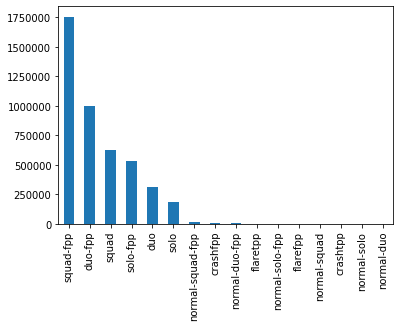

In [0]:
df_stats.matchType.value_counts().plot(kind='bar')

In [0]:
remove_list = ['squad-fpp', 'duo-fpp', 'squad', 'solo-fpp', 'duo', 'solo']
df_standard_modes = df_stats[df_stats.matchType.isin(remove_list)]

In [0]:
print(get_mean_median(df_standard_modes))

             duo   duo-fpp      solo  solo-fpp     squad  squad-fpp
median  0.469400  0.478300  0.468100  0.489100  0.423100   0.444400
mean    0.482777  0.485801  0.473814  0.491835  0.451908   0.464764


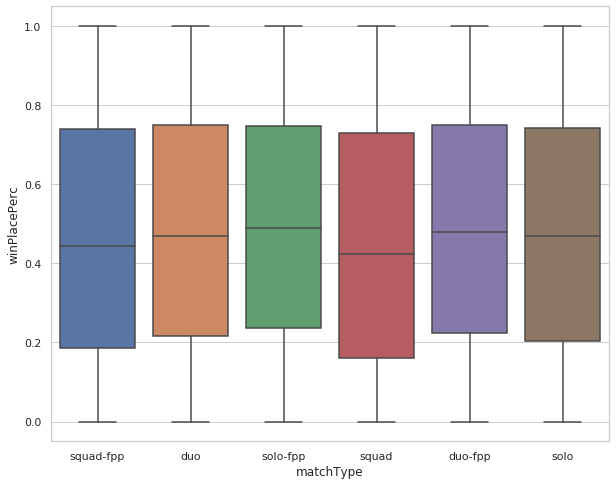

In [0]:
#df_squad_fpp
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=df_standard_modes.matchType, y=df_standard_modes.winPlacePerc, ax=ax)

In [0]:
df_event_modes = df_stats[~(df_stats.matchType.isin(remove_list))]

In [0]:
df_event_modes.matchType.unique()

array(['normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

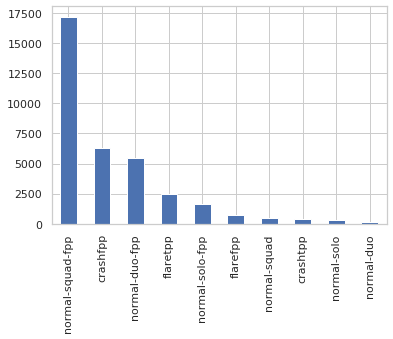

In [0]:
df_event_modes.matchType.value_counts().plot(kind='bar')

In [0]:
print(get_mean_median(df_event_modes))

        crashfpp  crashtpp  ...  normal-squad  normal-squad-fpp
median  0.469400  0.482800  ...      0.555600          0.500000
mean    0.474711  0.484515  ...      0.524561          0.502411

[2 rows x 10 columns]


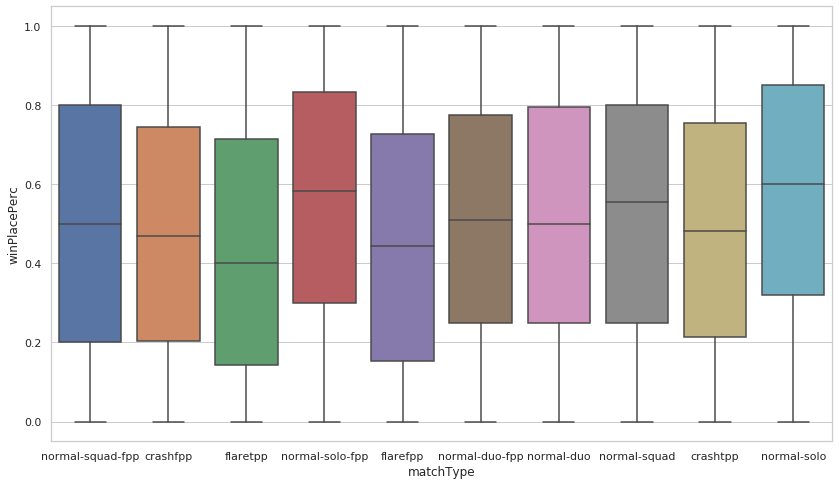

In [0]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(x=df_event_modes.matchType, y=df_event_modes.winPlacePerc, ax=ax)

## Distances analysis

In [0]:
df_stats.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [0]:
df_distances = df_stats[['walkDistance', 'swimDistance', 'rideDistance', 'winPlacePerc']]

In [0]:
df_distances.head()

,walkDistance,swimDistance,rideDistance,winPlacePerc
0,244.80,0.00,0.0000,0.4444
1,1434.00,11.04,0.0045,0.6400
2,161.80,0.00,0.0000,0.7755
3,202.70,0.00,0.0000,0.1667
4,49.75,0.00,0.0000,0.1875


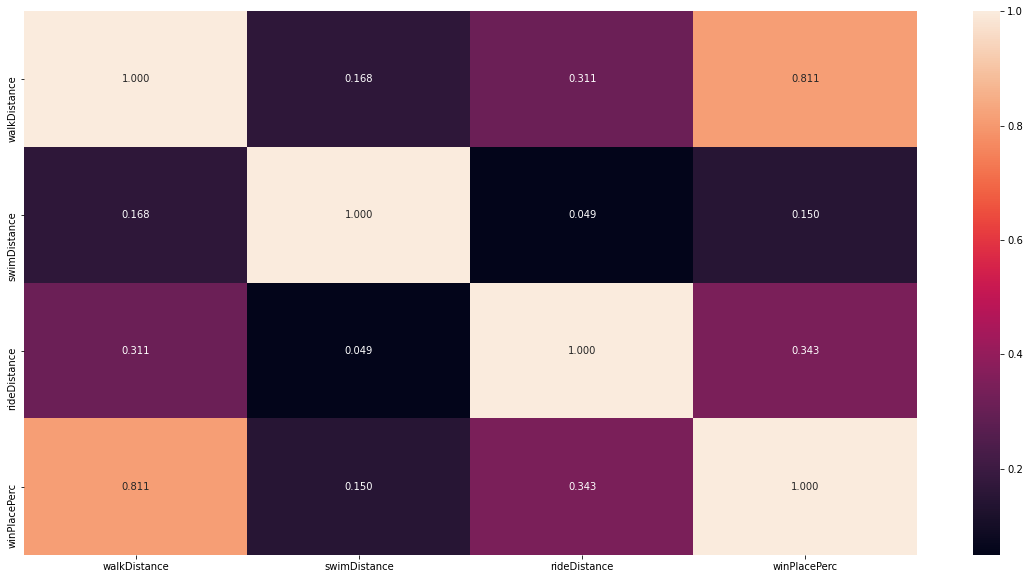

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_distances.corr(), ax=ax, annot=True, fmt=".3f")

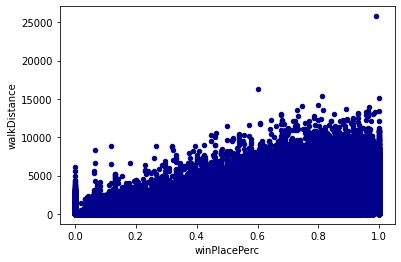

In [0]:
ax1 = df_distances.plot.scatter(x='winPlacePerc',
                      y='walkDistance',
                      c='DarkBlue')

## Feature selection

### Univariate Selection
Slepa ulicka, This label_y has continuous values.

But you have specified the scoring function as chi2. And according to the documentation of chi2, this is only valid for classification tasks.

Used mutual_info_regression

In [0]:
df_numbers = df_stats.select_dtypes(include=np.number)
df_numbers[df_numbers < 0] = 0
X = df_numbers.iloc[:,0:(len(df_numbers.columns)-1)] #independent columns
y = df_stats.winPlacePerc  #target
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


### Pearson correlations

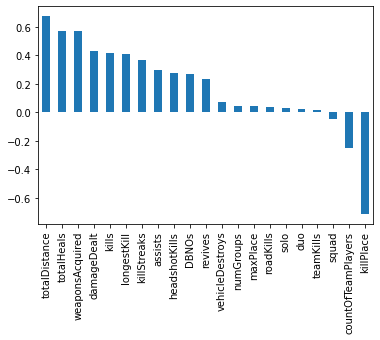

In [0]:
cor = df_stats.corr()
cor_target = cor["winPlacePerc"]
#Selecting highly correlated features
sorted = cor_target.sort_values(ascending=False)
sorted = sorted[1:]
sorted.plot(kind='bar')
plt.show()

# Preprocess

In [0]:
def remove_afk(df):
  indices_to_drop = df[df['walkDistance'] == 0].sort_values(by='kills').index
  df.drop(indices_to_drop, inplace=True)
  return df

#TODO totalNumberOfPlayersInTeam #shoutout to https://www.kaggle.com/deffro/eda-is-fun#
def count_players(df):
  df = df.assign(countOfTeamPlayers=df.groupby('groupId').groupId.transform('count'))
  return df

def drop_unnecessary(df):
  df.drop(['Id', 'groupId', 'matchId', 'matchDuration', 
           'winPoints', 'killPoints', 'rankPoints'], inplace = True, axis = 1)
  return df
#TODO map vsetky mody na solo duo a squad
def map_modes(df):
  solo_list = ['solo-fpp', 'normal-solo', 'normal-solo-fpp']
  duo_list = ['normal-duo', 'normal-duo-fpp', 'crashtpp', 'crashfpp', 'duo-fpp']
  squad_list = ['squad-fpp', 'normal-squad-fpp', 'flaretpp', 'flarefpp', 'normal-squad']
  df.loc[df.matchType.isin(solo_list), 'matchType'] = 'solo'
  df.loc[df.matchType.isin(duo_list), 'matchType'] = 'duo'
  df.loc[df.matchType.isin(squad_list), 'matchType'] = 'squad'
  return df

#TODO zabitie v hre kde je <100 hracov ma iny impakt ako zabitie v hre kde je >100 hracov ?

def reduce_agg_columns(df, new_column, columns):
  df[new_column] = df[list(columns)].sum(axis=1)
  df.drop(columns, inplace=True, axis = 1)
  return df

def encode_variables(df):
  features = pd.get_dummies(df.matchType)
  df = pd.concat([df, features], axis=1)
  df.drop('matchType', inplace=True, axis = 1)
  return df

In [0]:
df_stats = pd.read_csv('gdrive/My Drive/OZNAL/new/train_V2.csv')

In [0]:
df_stats = (df_stats.pipe(reduce_agg_columns, new_column='totalHeals', columns=['boosts', 'heals'])
         .pipe(map_modes)
         .pipe(remove_afk)
         .pipe(count_players)
         .pipe(reduce_agg_columns, new_column='totalDistance', columns=['walkDistance', 'swimDistance', 'rideDistance'])
         .pipe(drop_unnecessary)
         .pipe(encode_variables))

In [0]:
df_stats.to_pickle("gdrive/My Drive/OZNAL/new/featured_dataset.pkl")

In [0]:
df_stats = pd.read_csv('gdrive/My Drive/OZNAL/new/train_V2.csv')
df_stats = remove_afk(df_stats)
df_stats = encode_variables(df_stats)
df_independent = df_stats.drop(['Id', 'groupId', 'matchId'], axis = 1)
df_independent.to_pickle("gdrive/My Drive/OZNAL/new/nonfeatured_dataset.pkl")

In [0]:
df_stats.head()

,assists,damageDealt,DBNOs,headshotKills,killPlace,kills,killStreaks,longestKill,maxPlace,numGroups,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalHeals,countOfTeamPlayers,totalDistance,duo,solo,squad
0,0,0.00,0,0,60,0,0,0.00,28,26,0,0,0,0,1,0.4444,0,4,244.8000,0,0,1
1,0,91.47,0,0,57,0,0,0.00,26,25,0,0,0,0,5,0.6400,0,4,1445.0445,0,0,1
2,1,68.00,0,0,47,0,0,0.00,50,47,0,0,0,0,2,0.7755,0,2,161.8000,1,0,0
3,0,32.90,0,0,75,0,0,0.00,31,30,0,0,0,0,3,0.1667,0,1,202.7000,0,0,1
4,0,100.00,0,0,45,1,1,58.53,97,95,0,0,0,0,2,0.1875,0,1,49.7500,0,1,0


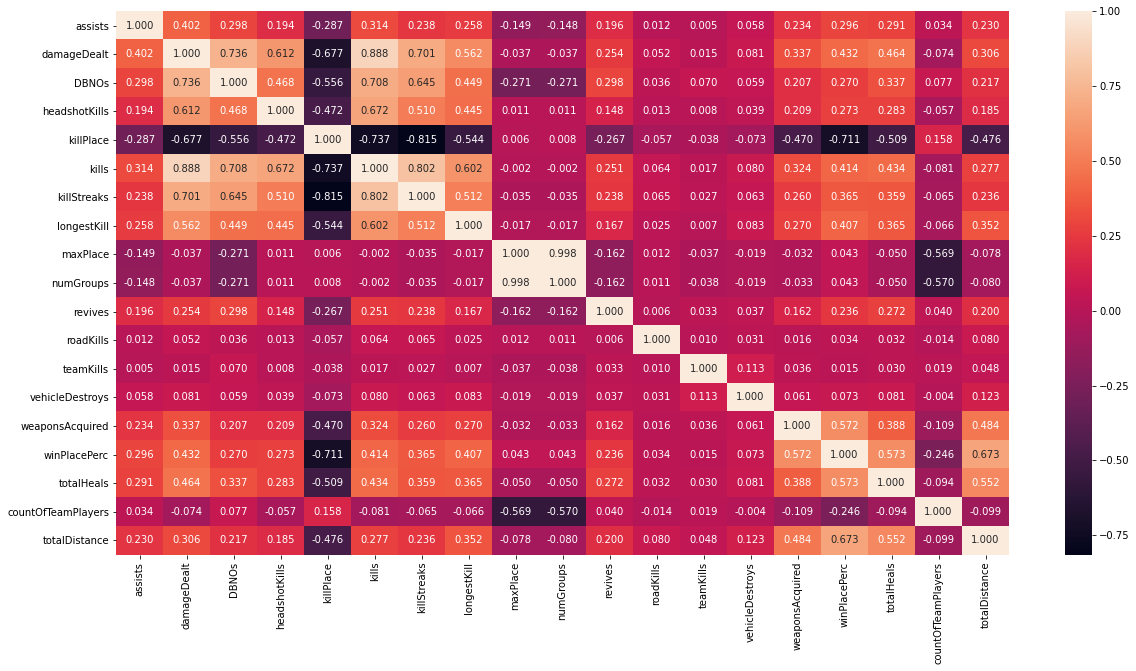

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df_stats.corr(), ax=ax, annot=True, fmt=".3f")

# Experiments

## Hyperparameter tunning

### Grid Search

#### LGBM

In [0]:
#GRIDSEARCH
df_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
X = df_pickle.drop(['winPlacePerc'], axis = 1)
y = df_pickle.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#Train
param_grid = {
    'num_leaves': [31, 128, 256],
    'learning_rate': [0.1,0.05,0.03],
    'n_estimators': [10000, 100000,1000]

}
params = {}
params['random_state'] = 42
params['boosting_type'] = 'gbdt'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
lgb_estimator = lgb.LGBMRegressor(**params, n_estimators=10000)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid)
lgb_model = gsearch.fit(X=X_train, y=y_train)
print(lgb_model.best_params_, lgb_model.best_score_)

#### XGBOOST

In [0]:
#TODO: GRID SEARCH 

### Random search

In [0]:
#RF
df_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
df_pickle = df_pickle.sample(100000)
X = df_pickle.drop(['winPlacePerc'], axis = 1)
y = df_pickle.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
hyperF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100, 300, 500]
}
forest = RandomForestRegressor(random_state=0)
gridF = RandomizedSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

## Random Forest
TODO:   
One-hot encoded categorical variables  
Split data into features and labels  
Converted to arrays  
Split data into training and testing sets

### Without feature engineering




In [0]:
df_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/nonfeatured_dataset.pkl')
X = df_pickle.drop(['winPlacePerc'], axis = 1)
y = df_pickle.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_absolute_error(y_test, y_pred)

### With feature engineering

In [0]:
df_featured = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
X = df_featured.drop(['winPlacePerc'], axis = 1)
y = df_featured.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
regressor = RandomForestRegressor(n_estimators=500, random_state=0, max_depth=15)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.06568627348860498

### With pearson top 10

In [0]:
independent_list = sorted[:10].keys()

In [0]:
df_independent = df_stats.loc[:, df_stats.columns.isin(independent_list)]

In [0]:
df_independent

,assists,damageDealt,DBNOs,headshotKills,kills,killStreaks,longestKill,weaponsAcquired,totalHeals,totalDistance
0,0,0.00,0,0,0,0,0.00,1,0,244.8000
1,0,91.47,0,0,0,0,0.00,5,0,1445.0445
2,1,68.00,0,0,0,0,0.00,2,0,161.8000
3,0,32.90,0,0,0,0,0.00,3,0,202.7000
4,0,100.00,0,0,1,1,58.53,2,0,49.7500
...,...,...,...,...,...,...,...,...,...,...
4446961,0,0.00,0,0,0,0,0.00,3,0,2311.0000
4446962,0,44.15,0,0,0,0,0.00,6,1,81.7000
4446963,0,59.06,0,0,0,0,0.00,4,0,790.8840
4446964,0,180.40,1,1,2,1,98.50,8,6,2748.0000


In [0]:
from sklearn.metrics import r2_score
X = df_independent
y = df_stats.winPlacePerc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
for i in [1,5,6,7]:
  regressor = RandomForestRegressor(n_estimators=i, random_state=0)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  print(r2_score(y_test, y_pred))

0.5262609387781149
0.6864327965950898
0.6929894097248046
0.6975800309465442


## LGBM

### With feature engineering

In [0]:
X = df_stats.drop('winPlacePerc', axis = 1)
y = df_stats.winPlacePerc
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [0]:
params = {}
params['learning_rate'] = 0.05 #0.05
params['random_state'] = 42
params['boosting_type'] = 'gbdt'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 128 #128 predtym #31
params['bagging_fraction'] = 0.7 #nepomohlo
params['feature_fraction'] = 0.7 #nepomohlo

In [0]:
y_pred = clf.predict(x_test)

In [0]:
mean_absolute_error(y_test, y_pred)

0.06698015598396646

### Parameter tunnings

In [0]:
print(json.dumps(params, indent = 4))
reg = lgb.LGBMRegressor(**params, n_estimators=10000)
reg.fit(x_train, y_train)
pred = reg.predict(x_test, num_iteration=reg.best_iteration_)
mean_absolute_error(y_test,pred)

{
    "learning_rate": 0.1,
    "random_state": 42,
    "boosting_type": "gbdt",
    "metric": "mae",
    "sub_feature": 0.5,
    "num_leaves": 31,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7
}


0.06300051962359814

In [0]:
print(json.dumps(params, indent = 4))
reg = lgb.LGBMRegressor(**params, n_estimators=10000)
reg.fit(x_train, y_train)
pred = reg.predict(x_test, num_iteration=reg.best_iteration_)
mean_absolute_error(y_test,pred)

{
    "learning_rate": 0.1,
    "random_state": 42,
    "boosting_type": "gbdt",
    "metric": "mae",
    "sub_feature": 0.5,
    "num_leaves": 128
}


0.06333775733145595

In [0]:
print(json.dumps(params, indent = 4))
reg = lgb.LGBMRegressor(**params, n_estimators=10000)
reg.fit(x_train, y_train)
pred = reg.predict(x_test, num_iteration=reg.best_iteration_)
mean_absolute_error(y_test,pred)

{
    "learning_rate": 0.05,
    "random_state": 42,
    "boosting_type": "gbdt",
    "metric": "mae",
    "sub_feature": 0.5,
    "num_leaves": 128,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7
}


0.06297821374894122

In [0]:
df_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
X = df_pickle.drop('winPlacePerc', axis = 1)
y = df_pickle.winPlacePerc
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
params = {
        "objective" : "regression", 
        "metric" : "mae", 
        "num_leaves" : 149, 
        "learning_rate" : 0.03, 
        "bagging_fraction" : 0.9,
        "bagging_seed" : 0, 
        "num_threads" : 4,
        "colsample_bytree" : 0.5,
        'min_data_in_leaf':1900, 
        'min_split_gain':0.00011,
        'lambda_l2':9
}
model = lgb.LGBMRegressor(**params, num_boost_round=9400,verbose_eval=100)
model.fit(x_train, y_train)
fImp = list(model.feature_importances_)
pred = model.predict(x_test, num_iteration=model.best_iteration_)
print(mean_absolute_error(y_test, pred))
print(np.sqrt(mean_squared_error(y_test, pred)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.06315114799968802
0.08768943964257694


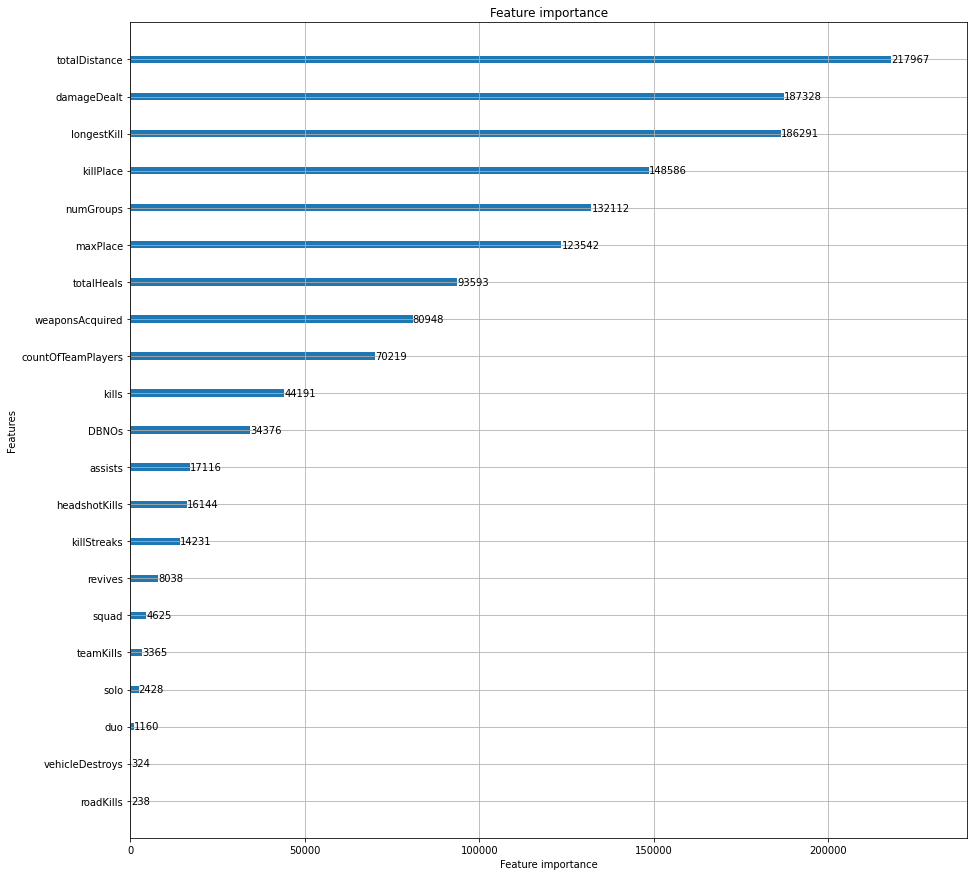

In [0]:
ax = lgb.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()


## XGBOOST

In [0]:
df_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
X = df_pickle.drop(['winPlacePerc'], axis = 1)
y = df_pickle.winPlacePerc
data_dmatrix = xgb.DMatrix(data=X, label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators=10000)
xg_reg.fit(X_train,y_train)
pred = xg_reg.predict(X_test)
mean_absolute_error(y_test, pred)

[21:29:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.06329096531445616

# Feature selection

## Recursive Feature Elimination

In [0]:
def load_data(need_subsample, clean_dataset):
  read_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
  if need_subsample is True:
    read_pickle = read_pickle.sample(100000)
  if clean_dataset is False:
    X = read_pickle[['DBNOs', 'assists','countOfTeamPlayers','damageDealt','duo','killPlace','killStreaks','kills','longestKill','maxPlace','numGroups','revives','solo','squad','teamKills','totalDistance','totalHeals','weaponsAcquired','roadKills','vehicleDestroys','headshotKills']] 
  else:
    X = read_pickle.drop(['winPlacePerc'], axis=1)
  y = read_pickle.winPlacePerc
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
  return x_train, x_test, y_train, y_test

def load_nonfdata():
  read_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/nonfeatured_dataset.pkl')
  X = read_pickle.drop(['winPlacePerc'], axis=1)
  y = read_pickle.winPlacePerc
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
  return x_train, x_test, y_train, y_test

In [0]:
params = {
    "learning_rate": 0.05,
    "random_state": 42,
    "boosting_type": "gbdt",
    "metric": "mae",
    "sub_feature": 0.5,
    "num_leaves": 128,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7
}   
high_score = -999
nof = 0        
x_train, x_test, y_train, y_test = load_data(False, False)
lgb_reg = lgb.LGBMRegressor(**params, n_estimators=100)
for i in range(5,21):
  rfe = RFE(lgb_reg,i)
  x_train_rfe = rfe.fit_transform(x_train,y_train)
  x_test_rfe = rfe.transform(x_test)
  lgb_reg.fit(x_train_rfe,y_train)
  score = lgb_reg.score(x_test_rfe,y_test)
  print('NOF %d - Score %f' %(i, score))
  if(score>high_score):
    high_score = score
    nof = i
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

NOF 5 - Score 0.868388
NOF 6 - Score 0.870886
NOF 7 - Score 0.898500
NOF 8 - Score 0.903367
NOF 9 - Score 0.907504
NOF 10 - Score 0.909419
NOF 11 - Score 0.909469
NOF 12 - Score 0.910251
NOF 13 - Score 0.909593
NOF 14 - Score 0.909010
NOF 15 - Score 0.910349
NOF 16 - Score 0.910150
NOF 17 - Score 0.910289
NOF 18 - Score 0.910622
NOF 19 - Score 0.910502
NOF 20 - Score 0.910587
Optimum number of features: 18
Score with 18 features: 0.910622


In [0]:
rfe = RFE(lgb_reg,18)
x_train_rfe = rfe.fit_transform(x_train,y_train)
x_test_rfe = rfe.transform(x_test)
lgb_reg.fit(x_train_rfe,y_train)
score = lgb_reg.score(x_test_rfe,y_test)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

[(1, 'DBNOs'), (1, 'assists'), (1, 'countOfTeamPlayers'), (1, 'damageDealt'), (1, 'duo'), (1, 'killPlace'), (1, 'killStreaks'), (1, 'kills'), (1, 'longestKill'), (1, 'maxPlace'), (1, 'numGroups'), (1, 'revives'), (1, 'solo'), (1, 'squad'), (1, 'teamKills'), (1, 'totalDistance'), (1, 'totalHeals'), (1, 'weaponsAcquired'), (2, 'roadKills'), (3, 'vehicleDestroys'), (4, 'headshotKills')]


# Hyperparameter tunning


## GridSearch 

### LGBM

In [5]:
x_train, x_test, y_train, y_test = load_data(True, False)
param_grid = {
    'num_leaves': [31, 128, 256],
    'sub_feature': [0.5,0.7],
    "bagging_fraction": [0.3,0.5,0.7],
    "feature_fraction": [0.3,0.5,0.7],
    'learning_rate': [0.1,0.05,0.03],
    'n_estimators': [10000,5000,1000]
}
lgb_estimator = lgb.LGBMRegressor()
gsearch = GridSearchCV(lgb_estimator, param_grid)
lgb_model = gsearch.fit(X=x_train, y=y_train)
print(lgb_model.best_params_, lgb_model.best_score_)

{'sub_feature': 0.5, 'num_leaves': 31, 'n_estimators': 1000, 'learning_rate': 0.1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7} 0.9083577570136148


### XGBOOST

In [6]:
x_train, x_test, y_train, y_test = load_data(True, False)
xg_reg = xgb.XGBRegressor()
param_grid = {
    'max_depth': [5,10,15],
    'learning_rate': [0.1,0.01,0.5,0.03],
    'n_estimators': [10000,5000,1000],
    'alpha': [5,7,10],
    'colsample_bytree': [0.3, 0.5, 0.1]
}
gsearch = GridSearchCV(xg_reg, param_grid)
xgb_model = gsearch.fit(X=x_train, y=y_train)
print(xgb_model.best_params_, xgb_model.best_score_)

[20:43:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:13:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:14:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## RandomSearch

### Random Forest

In [3]:
X_train, X_test, y_train, y_test = load_data(True, False)
hyperF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100, 300, 500]
}
forest = RandomForestRegressor(random_state=0)
gridF = RandomizedSearchCV(forest, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


In [4]:
print(bestF.best_params_, bestF.best_score_)

{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True} 0.8855472066090436


# Train

## XGBOOST

### Featured dataset (clean)

In [7]:
x_train, x_test, y_train, y_test = load_data(False, True)
#{'n_estimators': 10000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 10}
t = time.process_time()
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators=1000)
xg_reg.fit(x_train,y_train)
pred = xg_reg.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

[20:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.068410 - RMSE: 0.094305
4320.51403537


### RFE featured dataset

In [8]:
x_train, x_test, y_train, y_test = load_data(False, False)
#{'n_estimators': 10000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 10}
t = time.process_time()
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators=1000)
xg_reg.fit(x_train,y_train)
pred = xg_reg.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

[21:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.068685 - RMSE: 0.094676
4169.130673802


### Nonfeatured dataset

In [11]:
x_train, x_test, y_train, y_test = load_nonfdata()
#{'n_estimators': 10000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 10}
t = time.process_time()
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators=1000)
xg_reg.fit(x_train,y_train)
pred = xg_reg.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

[22:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.062951 - RMSE: 0.087361
5997.0692936139985


## LGBM

### Featured dataset (clean)

In [4]:
x_train, x_test, y_train, y_test = load_data(False, True)
#{'sub_feature': 0.5, 'num_leaves': 31, 'n_estimators': 1000, 'learning_rate': 0.1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7}
params = {
    "objective" : "regression", 
    "metric" : "mae", 
    "sub_feature":0.5,
    "num_leaves":31,
    "learning_rate":0.1,
    "feature_fraction":0.3,
    "bagging_fraction":0.7
}
t = time.process_time()
model = lgb.LGBMRegressor(**params ,n_estimators=1000)
model.fit(x_train, y_train)
pred = model.predict(x_test, num_iteration=model.best_iteration_)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.063958 - RMSE: 0.088410
505.63736649500004


### RFE Featured dataset

In [5]:
x_train, x_test, y_train, y_test = load_data(False, False)
#{'sub_feature': 0.5, 'num_leaves': 31, 'n_estimators': 1000, 'learning_rate': 0.1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7}
params = {
    "objective" : "regression", 
    "metric" : "mae", 
    "sub_feature":0.5,
    "num_leaves":31,
    "learning_rate":0.1,
    "feature_fraction":0.3,
    "bagging_fraction":0.7
}
t = time.process_time()
model = lgb.LGBMRegressor(**params ,n_estimators=1000)
model.fit(x_train, y_train)
pred = model.predict(x_test, num_iteration=model.best_iteration_)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.063902 - RMSE: 0.088388
470.488713567


### Nonfeatured dataset

In [5]:
x_train, x_test, y_train, y_test = load_nonfdata()
#{'sub_feature': 0.5, 'num_leaves': 31, 'n_estimators': 1000, 'learning_rate': 0.1, 'feature_fraction': 0.3, 'bagging_fraction': 0.7}
params = {
    "objective" : "regression", 
    "metric" : "mae", 
    "sub_feature":0.5,
    "num_leaves":31,
    "learning_rate":0.1,
    "feature_fraction":0.3,
    "bagging_fraction":0.7
}
t = time.process_time()
model = lgb.LGBMRegressor(**params ,n_estimators=1000)
model.fit(x_train, y_train)
pred = model.predict(x_test, num_iteration=model.best_iteration_)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.057840 - RMSE: 0.080039
647.712582384


## Random Forest

### Featured dataset (clean)

In [6]:
x_train, x_test, y_train, y_test = load_data(False, True)
#{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}
t = time.process_time()
regr = RandomForestRegressor(max_depth=110, 
                             random_state=0, n_estimators=100,
                             min_samples_split=8, min_samples_leaf=3,
                             max_features=3, bootstrap=True)
regr.fit(x_train, y_train)
pred = regr.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.066790 - RMSE: 0.091732
807.3696691570001


### RFE Featured dataset


In [7]:
x_train, x_test, y_train, y_test = load_data(False, False)
#{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}
t = time.process_time()
regr = RandomForestRegressor(max_depth=110, 
                             random_state=0, n_estimators=100,
                             min_samples_split=8, min_samples_leaf=3,
                             max_features=3, bootstrap=True)
regr.fit(x_train, y_train)
pred = regr.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.066751 - RMSE: 0.091681
733.8549914849998


### Nonfeatured dataset

In [8]:
x_train, x_test, y_train, y_test = load_nonfdata()
#{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}
t = time.process_time()
regr = RandomForestRegressor(max_depth=110, 
                             random_state=0, n_estimators=100,
                             min_samples_split=8, min_samples_leaf=3,
                             max_features=3, bootstrap=True)
regr.fit(x_train, y_train)
pred = regr.predict(x_test)
elapsed_time = time.process_time() - t
mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print('MAE: %f - RMSE: %f'%(mae,rmse))
print(elapsed_time)

MAE: 0.068551 - RMSE: 0.092811
745.0685787279999


# Evaluation

In [0]:
def subcategorybar(X, vals, width=0.5):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

## Error rate

### Featured dataset

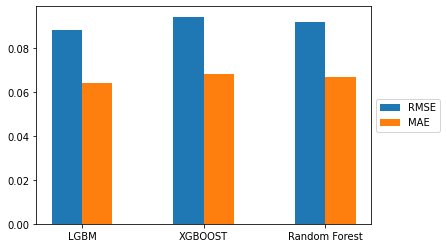

In [38]:
#https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
X = ['LGBM','XGBOOST', 'Random Forest']
RMSE = [0.088410,0.094305,0.091732]
MAE = [0.063958,0.068410,0.066790]
subcategorybar(X, [RMSE,MAE])
plt.legend(('RMSE', 'MAE'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Nonfeatured dataset

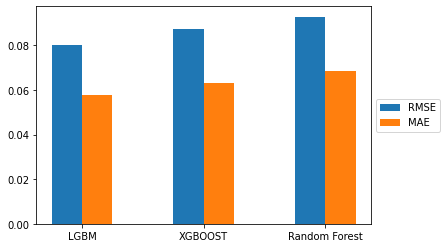

In [50]:
X = ['LGBM','XGBOOST', 'Random Forest']
#LGBM => MAE: 0.057840 - RMSE: 0.080039
#RF => MAE: 0.068551 - RMSE: 0.092811
#XG => MAE: 0.062951 - RMSE: 0.087361
RMSE = [0.080039,0.087361, 0.092811]
MAE = [0.057840,0.062951,0.068551]
subcategorybar(X, [RMSE,MAE])
plt.legend(('RMSE', 'MAE'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Time

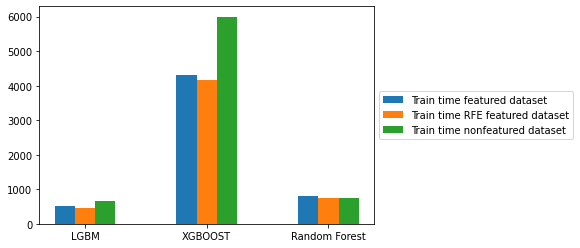

In [47]:
X = ['LGBM','XGBOOST', 'Random Forest']
timeFeat = [505.63736649500004,4320.51403537,807.3696691570001]
timeRFE = [470.488713567,4169.130673802,733.8549914849998]
timeNonF = [647.712582384,5997.0692936139985,745.0685787279999]
subcategorybar(X, [timeFeat,timeRFE,timeNonF])
plt.legend(('Train time featured dataset', 'Train time RFE featured dataset', 'Train time nonfeatured dataset'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [0]:
read_pickle = pd.read_pickle('gdrive/My Drive/OZNAL/new/featured_dataset.pkl')
read_pickle = read_pickle.sample(15)
read_pickle.to_csv('gdrive/My Drive/OZNAL/new/sample.csv')